In [10]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.metrics import Metric




In [11]:
cwd = os.getcwd()
# Read the data
used_dataset_dir = os.path.join(cwd, 'Used_Dataset')

# Read the data
weather_df_2022 = pd.read_csv(os.path.join(used_dataset_dir, 'weather_2022.csv'))
tidal_df_2022 = pd.read_csv(os.path.join(used_dataset_dir, 'tidal_daily_average_22.csv'))


In [12]:
# Ensure the 'Date' column is in datetime format
weather_df_2022.rename(columns={'Time (UTC)': 'Date'}, inplace=True)
tidal_df_2022.drop(columns=['Time (UTC)'], inplace=True)

weather_df_2022['Date'] = pd.to_datetime(weather_df_2022['Date'], errors='coerce')
tidal_df_2022['Date'] = pd.to_datetime(tidal_df_2022['Date'], errors='coerce')

# Merge the two dataframes
merged_df_2022 = pd.merge(weather_df_2022, tidal_df_2022, on='Date', how='inner')
merged_data_sorted = merged_df_2022.sort_values(by='Date')


merged_data_sorted.drop(columns=['Date'], inplace=True)

print(merged_data_sorted.head())


     Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ddd_x  ff_avg    rad(m)
0  24.4  30.8  28.3    81.0   6.1  7.6   4.0  280.0     3.0  0.326968
1  25.3  30.1  27.7    82.0   3.5  4.0   4.0  290.0     2.0  0.270584
2  24.1  30.1  27.8    81.0  16.7  2.4   5.0  290.0     3.0  0.079565
3  24.6  30.1  26.7    84.0   9.5  2.0   6.0  260.0     3.0  0.001373
4  24.5  28.8  26.7    80.0   6.7  2.2   6.0  260.0     2.0 -0.024731


In [ ]:


# Display the first few rows of the weather_df_2022 dataframe
print(weather_df_2022.head())

# Summary statistics of the dataframe
print(weather_df_2022.describe())

# Visualize the data

# Set the size of the plot
plt.figure(figsize=(14, 8))

# Plot the distribution of temperatures
sns.histplot(weather_df_2022['Tavg'], kde=True, bins=30)
plt.title('Distribution of Average Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Frequency')
plt.show()

# Plot the time series of average temperature
plt.figure(figsize=(14, 8))
plt.plot(weather_df_2022['Date'], weather_df_2022['Tavg'], label='Average Temperature')
plt.title('Time Series of Average Temperature')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.show()

Correlation Matrix

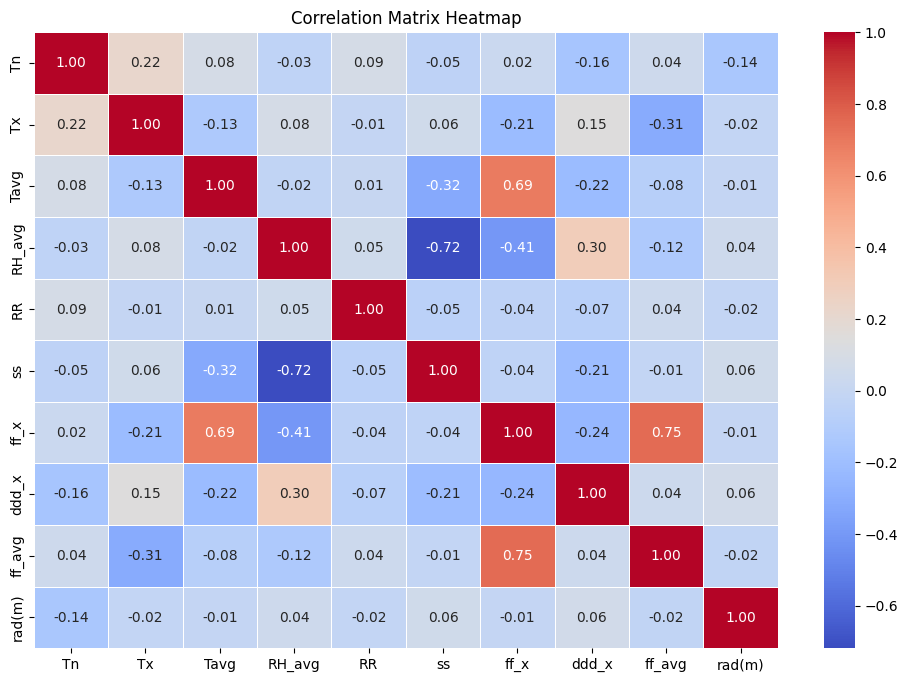

In [13]:

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title of the heatmap
plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()

Linear Regression Process Start Here


In [14]:
# Custom Accuracy Metric: Predictions within a tolerance range
class RegressionAccuracy(Metric):
    def __init__(self, name="regression_accuracy", tolerance=0.05, **kwargs):
        super().__init__(name=name, **kwargs)
        self.tolerance = tolerance
        self.correct_predictions = self.add_weight(name="correct_predictions", initializer="zeros")
        self.total_predictions = self.add_weight(name="total_predictions", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        error = tf.abs(y_true - y_pred)
        within_tolerance = tf.cast(error <= self.tolerance, tf.float32)
        self.correct_predictions.assign_add(tf.reduce_sum(within_tolerance))
        self.total_predictions.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.correct_predictions / self.total_predictions

    def reset_states(self):
        self.correct_predictions.assign(0)
        self.total_predictions.assign(0)

# Add the custom metric to the model
accuracy_metric = RegressionAccuracy(tolerance=0.05)


In [15]:
X = merged_data_sorted[['Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x', 'ff_avg']]
y = merged_data_sorted['rad(m)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    BatchNormalization(),  # Batch normalization to stabilize training
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),  # Third hidden layer
    Dense(1)  # Output layer
])

# Compile the model
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.compile(optimizer='adam', loss='mse', metrics=['mae', accuracy_metric])

# Train the model
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), batch_size=16, verbose=1)
# history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, verbose=1)

results = model.evaluate(X_test, y_test, verbose=1)

# Display the results
final_loss = results[0]
final_mae = results[1]
final_accuracy = results[2]

print(f"Final Loss: {final_loss:.4f}")
print(f"Final MAE: {final_mae:.4f}")
print(f"Final Accuracy: {final_accuracy:.4f}")


Epoch 1/150


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1129 - mae: 0.1682 - regression_accuracy: 0.3205 - val_loss: 0.0095 - val_mae: 0.0766 - val_regression_accuracy: 0.4247
Epoch 2/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - mae: 0.0824 - regression_accuracy: 0.3396 - val_loss: 0.0094 - val_mae: 0.0754 - val_regression_accuracy: 0.4247
Epoch 3/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - mae: 0.0788 - regression_accuracy: 0.4487 - val_loss: 0.0095 - val_mae: 0.0746 - val_regression_accuracy: 0.4521
Epoch 4/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - mae: 0.0868 - regression_accuracy: 0.3385 - val_loss: 0.0094 - val_mae: 0.0748 - val_regression_accuracy: 0.4384
Epoch 5/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - mae: 0.0787 - regression_accuracy: 0.4180 - val_loss: 0.0094 - val_mae: 0.0746 - val_regression_accuracy: 0.4384
Epoch 6/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - mae: 0.0788 - regression_accuracy: 0.37

In [16]:

# Define a function for making predictions
def predict_rad(features, scaler, model):
    """
    Predict rad(m) value based on input weather features.

    Parameters:
        features (dict): A dictionary containing all feature values (Tn, Tx, Tavg, RH_avg, RR, ss, ff_x, ddd_x, ff_avg).
        scaler (StandardScaler): Scaler used to normalize the features.
        model (Sequential): Trained deep learning model.

    Returns:
        float: Predicted rad(m) value.
    """
     # Convert input features to a DataFrame with the same column names as the scaler expects
    feature_df = pd.DataFrame([features])
    
    # Scale the input features using the trained scaler
    scaled_features = scaler.transform(feature_df)

    # Predict rad(m) using the trained model
    predicted_value = model.predict(scaled_features)

    # Return the predicted rad(m) value
    return predicted_value[0][0]


In [17]:
# Example input features
input_features = {
    'Tn': 24.5,      # Minimum temperature
    'Tx': 30.0,      # Maximum temperature
    'Tavg': 28.0,    # Average temperature
    'RH_avg': 80.0,  # Average relative humidity
    'RR': 5.0,       # Rainfall
    'ss': 6.0,       # Sunshine duration
    'ff_x': 4.0,     # Maximum wind speed
    'ddd_x': 270.0,  # Maximum wind direction
    'ff_avg': 3.0    # Average wind speed
}

# Call the prediction function
predicted_rad = predict_rad(input_features, scaler, model)
print(f"Predicted rad(m): {predicted_rad:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted rad(m): -0.0100
